In [1]:
"""
goal: take pics with & without noise apply atleast 10 different kinds of filter & see the output

outline
1) smoothening filters: mean, meadian, gaussian, bilateral, anisotropic, non local mean
2) edging filter: sobelx, sobely, laplacian, canny
3) sharpening: unsharp masking, laplacian based masking
4) morphing: erosion, dialation, opening, closing
5) frequency domain: low mask filter. (to do)








details:
-> mask means focusing on certain regions while ignoring the rest
1) smoothening filters: reduce noise & smoothen the img by taking avg of pixels in its neighbourhood
a) gaussain blur: (noise with normal distribution, better than mean for preserving edges, std= we can control degree of smoothening)
b) mean filter: for simple noise, fast noise reduction with minimal computational load, (avoid when u need to presever sharp edges)
c) median filter: good for salt pepper noise(cuz it has extram vals)

d) bilateral filter: edges remain sharp while reducing noise(irregular noise) but (requires more computation bad for real time)
-> conciders spacial closeness & intensity similarity, nearby pixels with similar colors are avg while edges arent tocuhed due to sharp
intensity change

e) *anisotropic filter: In homogeneous regions (low gradient), the filter diffuses (averages) the pixel values, reducing noise.
At edges (high gradient), diffusion is reduced, thereby preserving the edge information. but (requires more computation bad for real time)
-> keep the texture intact even if the obj is deep in the img

f) non local means: highest possible denoising without sacrifice on textture but  (requires much more computation bad for real time)
-> here we take mean but not from just the local pixels but from all the regions of the img, if there is a region in the img which is 
similar to that of the area we are smootheing then it would be given higher weight

2) edges
a) sobel: an approximation to a derivative of an img which is different in x & y direction meaning sobelx & sobely respectively .
-> used with greyscle imgs    -> we would also see a lot of edges which isnt technically an hard edge & the orientation of the edge
[-1 0 1]    [-1 -2 -1]
[-2 0 2]    [0 0 0]
[-1 0 1]    [1 2 1]
b) canny: is 1 step ahead of sobel in which the input of canny is the output of sobel by thinning all the edges to 1 pixels
-> we dont care abt how thick the edges are we only want to know where the edges are
-> finds the edges & does hystersis thresholding 
-> finds the edges: for every pixel try to find if it is the local maxima keeping in mind the orientation of the edges given by sobel
-> hystersis thresholding: remove the edges that are weak local maximums to get that sharp edge (we have a top threshold above which we 
always include and a bottom threshold below which we always exclude & the between is included if that edge is connecnetd to the top threshold)

c) lapalcian: The edges are at the 0 crossing(using 2ed derivative) of the img & doesent tell the orientation of the edges

3) sharpening
a) unsharp masking: creats a blur version of img using gaussian blur which is added to the original img
b) laplacian based sharpening 


4) morphing (change in shape & size): here we use a strcutring element. We make changes in the img if it matches 
certain condtions
a) erosion: process of reducing an img size & increasing its brightness
b) dialation: process of expanding an img size & increasing its brightness
c) opening: ersion is followed by dilation. It helps identify gaps in an img & isolate objs close to each other
d) closing: dialation is followed by ersion.

"""

'\ngoal: take pics with & without noise apply atleast 10 different kinds of filter & see the output\n\noutline\n1) smoothening filters: mean, meadian, gaussian, bilateral, anisotropic, non local mean\n2) edging filter: sobelx, sobely, laplacian, canny\n3) sharpening: unsharp masking, laplacian based masking\n4) morphing: erosion, dialation, opening, closing\n5) frequency domain: low mask filter.\n\n\n\n\n\n\n\n\ndetails:\n-> mask means focusing on certain regions while ignoring the rest\n1) smoothening filters: reduce noise & smoothen the img by taking avg of pixels in its neighbourhood\na) gaussain blur: (noise with normal distribution, better than mean for preserving edges, std= we can control degree of smoothening)\nb) mean filter: for simple noise, fast noise reduction with minimal computational load, (avoid when u need to presever sharp edges)\nc) median filter: good for salt pepper noise(cuz it has extram vals)\n\nd) bilateral filter: edges remain sharp while reducing noise(irreg

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.restoration import denoise_tv_chambolle
from skimage import io
from skimage.filters import unsharp_mask


imgs = ["image1.png", ] 
# "image2.png", "image3.png", "image4.png", "image5.png", "image7.png", "image6.png"

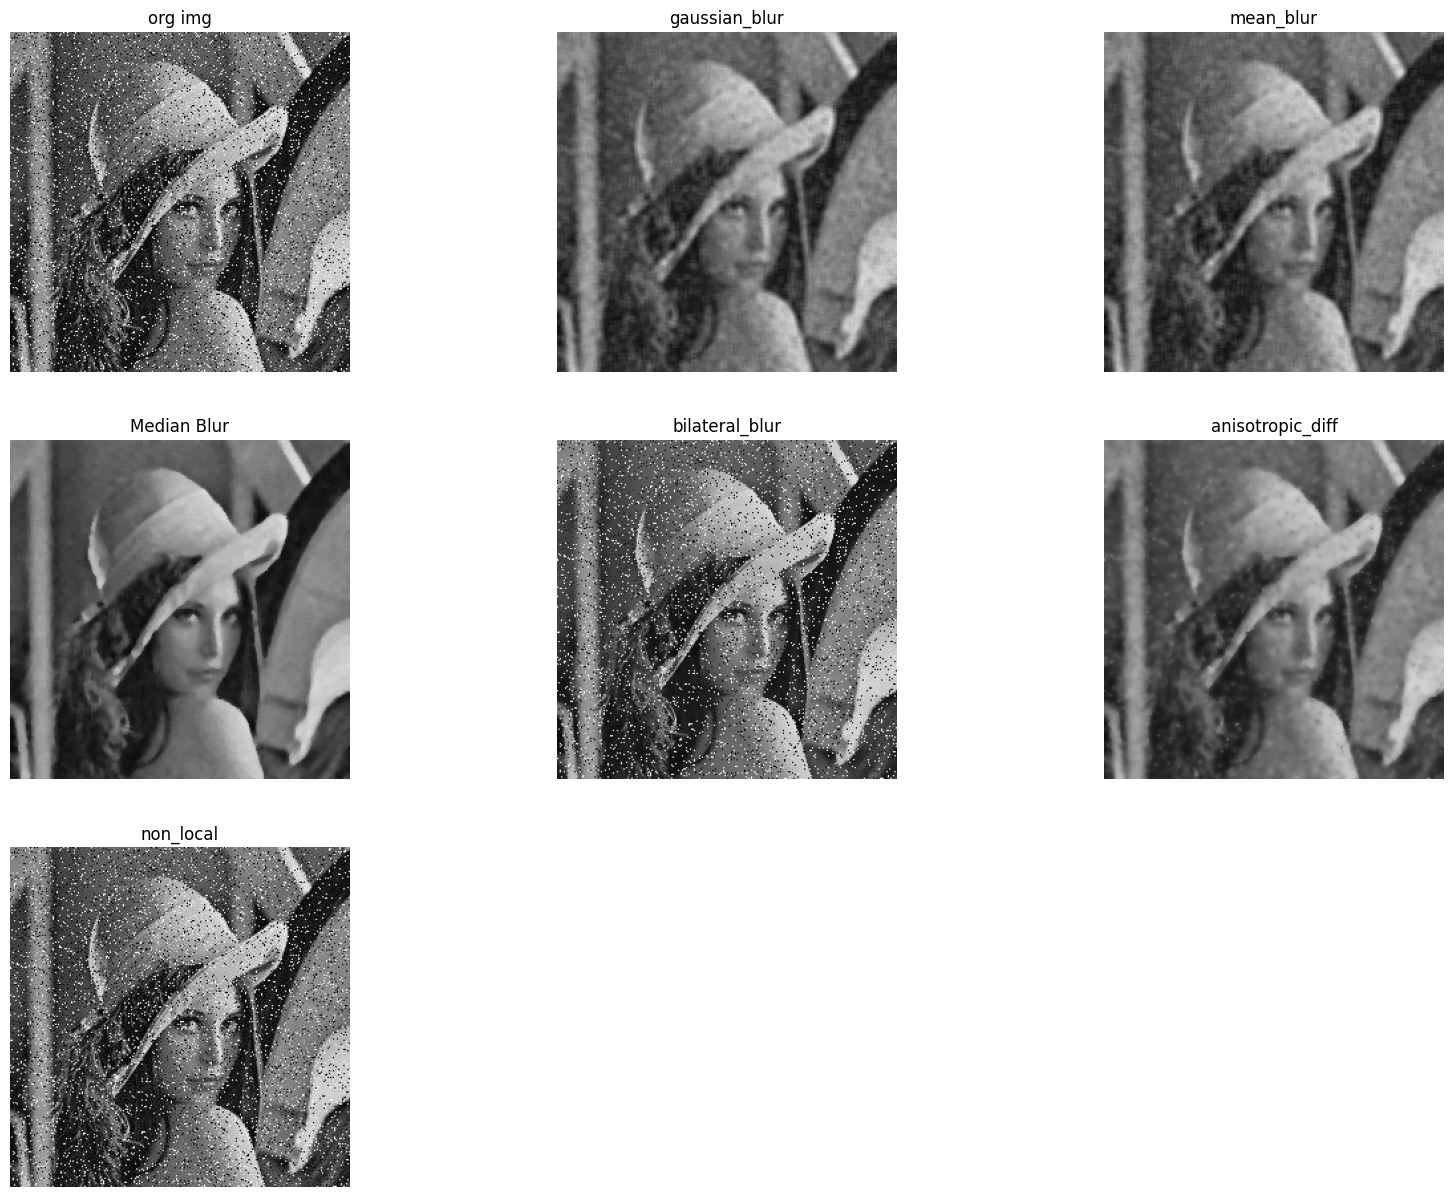

In [36]:
def smoothening(path, name):
    img1 = cv2.imread(path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


    gaussian_blur = cv2.GaussianBlur(img1, (5, 5), sigmaX=100)    # kernel size is (5,5)
    mean_blur = cv2.blur(img1, (5, 5))
    median_blur = cv2.medianBlur(img1, 5)  # higher k will give way more smoothening at the cost of fine details
    # we r using the same filter across all the pixel without thinking abt the context of the img
    
    bilateral_blur = cv2.bilateralFilter(img1, d=9, sigmaColor=75, sigmaSpace=75) 
    # d(low) filter wont be effective, d(large) fine details may be lost , 
    # sigmaColor(tells how many pixel intensity differnec e is allowed), sigmaSpace(max spacial distance b/w pixels).
    
    img_float = img1.astype(np.float32) / 255.0
    anisotropic_diff = denoise_tv_chambolle(img_float, weight=0.3, channel_axis=-1) # controls strength of denosing
    anisotropic_diff = np.uint8(anisotropic_diff * 255)

    img_bgr = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    non_local = cv2.fastNlMeansDenoisingColored(img_bgr, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    non_local = cv2.cvtColor(non_local, cv2.COLOR_BGR2RGB)  # back to RGB


    # Plot the original and blurred images
    titles = ['org img', 'gaussian_blur', 'mean_blur', 'Median Blur', 'bilateral_blur', 'anisotropic_diff', 'non_local']
    images = [img1, gaussian_blur, mean_blur, median_blur, bilateral_blur, anisotropic_diff, non_local]

    if not os.path.exists(name):
        os.makedirs(name)

    plt.figure(figsize=(20, 15))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')

    
    save_path = os.path.join(name, 'filtered.png')
    plt.savefig(save_path)
    plt.show()

for i in imgs:
    smoothening(i, i[:6])

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detect(path, folder_name):
    # 1) read the img & convert to req formats
    img = cv2.imread(path)    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # for display with plt    
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)  # img to grayscale
    

    # 2) apply each type of filter & tune hyper params
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    canny = cv2.Canny(gray, 100, 200)
    
    
    sobelx_abs = np.uint8(np.absolute(sobelx)) # convert floating point -> abs uint8
    sobely_abs = np.uint8(np.absolute(sobely))
    laplacian_abs = np.uint8(np.absolute(laplacian))
    

    # 3) create a sub folder for each filter img & display
    titles = ['org img', 'sobel x', 'sobel y', 'laplacian', 'canny']
    images = [img_rgb, sobelx_abs, sobely_abs, laplacian_abs, canny]

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(2, 3, i+1)
        if i == 0:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    
    save_path = os.path.join(folder_name, 'edge_detection.png')
    plt.savefig(save_path)
    plt.close()

imgs = ["image7.png", "image6.png", "image4.png"]
for img_path in imgs:
    folder = img_path[:6] + "_edge" 
    edge_detect(img_path, folder)

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sharpen_img(path, folder_name):
    # 1) Read the image and convert to RGB (for proper display with plt)
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2) Unsharp Masking & lapalcian
    sharpened_unsharp = unsharp_mask(img_rgb, radius=1, amount=1.0)
    
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian_abs = np.uint8(np.absolute(laplacian))
    laplacian_color = cv2.cvtColor(laplacian_abs, cv2.COLOR_GRAY2RGB) # for visualization
    sharpened_laplacian = cv2.addWeighted(img_rgb, 1.0, laplacian_color, 1.0, 0) # weight for org img & lapacian img is 1
    # org + lapalcian => empahsis on edges
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    titles = ['org img', 'sharpened_unsharp', 'sharpened_laplacian']
    images = [img_rgb, sharpened_unsharp, sharpened_laplacian]
    
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    
    save_path = os.path.join(folder_name, 'sharpened.png')
    plt.savefig(save_path)
    plt.close()


imgs = ["image9.png", "image6.png", "image4.png"]
for img_path in imgs:
    folder = img_path[:6] + "_sharpen"  
    sharpen_img(img_path, folder)


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def morph(path, folder_name):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    
    # operations:
    erosion = cv2.erode(img_rgb, kernel, iterations=1)
    dilation = cv2.dilate(img_rgb, kernel, iterations=1)
    opening = cv2.morphologyEx(img_rgb, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(img_rgb, cv2.MORPH_CLOSE, kernel)
    

    titles = ['Original Image', 'Erosion', 'Dilation', 'Opening', 'Closing']
    images = [img_rgb, erosion, dilation, opening, closing]
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    
    save_path = os.path.join(folder_name, 'morph_filters.png')
    plt.savefig(save_path)
    plt.close()

imgs = ["image7.png", "image6.png", "image4.png", "image8.png"]
for img_path in imgs:
    folder = img_path[:6] + "_morph"  
    morph(img_path, folder)


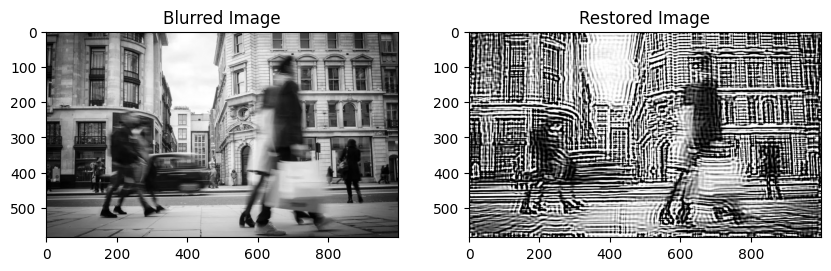

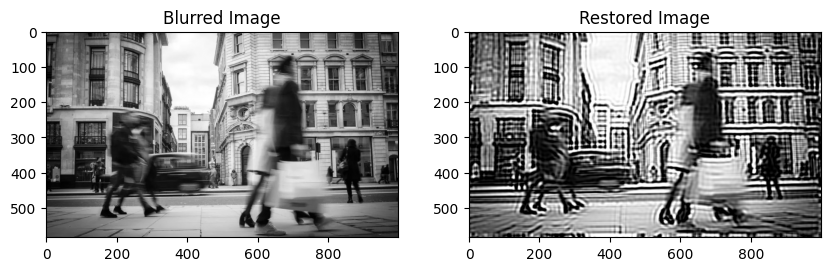

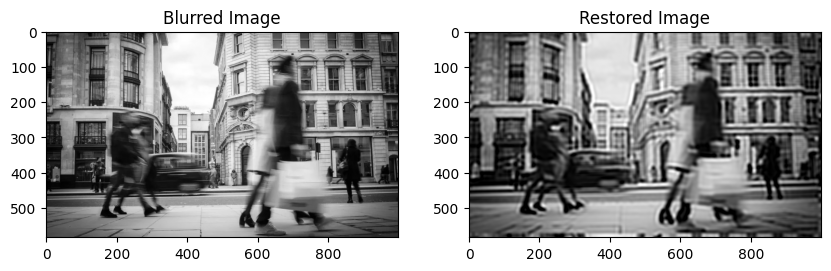

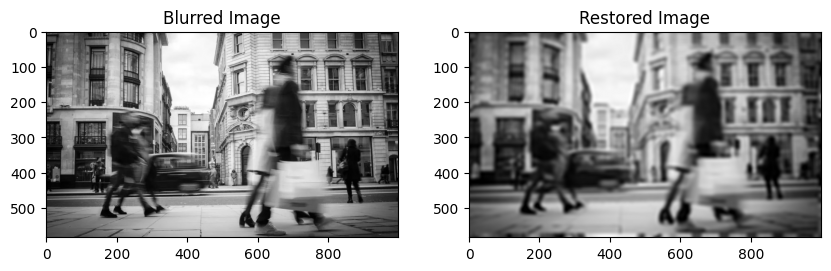

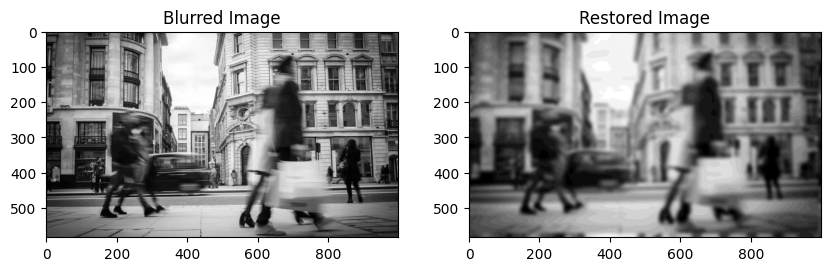

In [33]:
import numpy as np
import cv2

def wiener_deconvolution(blurred, kernel, K=0.1):
    """Apply Wiener Deconvolution to remove motion blur."""
    blurred_fft = np.fft.fft2(blurred)  # FFT of blurred image
    kernel_fft = np.fft.fft2(kernel, s=blurred.shape)  # FFT of kernel (same size as image)
    
    # Wiener deconvolution formula: (G * H*) / (|H|^2 + K)
    kernel_fft_conj = np.conj(kernel_fft)  # Complex conjugate
    deblurred_fft = (blurred_fft * kernel_fft_conj) / (np.abs(kernel_fft) ** 2 + K)
    
    deblurred = np.fft.ifft2(deblurred_fft).real  # Convert back to spatial domain
    return np.clip(deblurred, 0, 255).astype(np.uint8)

for i in [0.001, 0.01, 0.1, 1, 10]:

    # Example Usage:
    img = cv2.imread('image10.png', cv2.IMREAD_GRAYSCALE)
    kernel = cv2.getGaussianKernel(21, 5) @ cv2.getGaussianKernel(21, 5).T  # Example PSF
    restored_img = wiener_deconvolution(img, kernel, i)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title('Blurred Image')
    plt.subplot(1,2,2)
    plt.imshow(restored_img, cmap='gray')
    plt.title('Restored Image')
    plt.show()